In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge

import torch.nn as nn
import torch.optim as optim
import torch

from torch.utils.data import Dataset, DataLoader

# pd.set_option('display.max_columns', None)

np.random.seed(100)
torch.manual_seed(100)

## Read data

In [115]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/mimic-iv/sph_static.csv
/kaggle/input/mimic-iv/sph_dynamic.csv


In [116]:
# read data
dynamic_df = pd.read_csv('/kaggle/input/mimic-iv/sph_dynamic.csv')
static_df = pd.read_csv('/kaggle/input/mimic-iv/sph_static.csv')

In [117]:
dynamic_df.describe()

,stay_id,total_protein,calcium,creatinine,glucose,sodium,chloride,heart_rate,sbp,dbp,...,ph,lactate,pt,urineoutput,sofa_respiration,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal
count,7.024000e+03,94.000000,6091.000000,6763.000000,6580.000000,6810.000000,6783.000000,191.000000,129.000000,129.000000,...,20.00000,12.000000,3956.000000,82.000000,19.000000,1.0,1.0,152.000000,45.000000,0.0
mean,3.497892e+07,6.040426,8.389640,1.644019,142.289666,137.309545,102.067079,91.565445,119.531008,63.341085,...,7.35800,2.841667,18.826567,86.573171,1.631579,0.0,0.0,0.532895,0.666667,NaN
std,2.832325e+06,1.104372,0.820066,1.839893,89.875986,5.638384,6.731008,20.303089,22.348251,14.976412,...,0.09111,3.065485,11.588015,70.872173,0.683986,NaN,NaN,1.028841,0.929320,NaN
min,3.000414e+07,3.200000,4.200000,0.100000,30.000000,83.000000,62.000000,48.000000,45.000000,22.000000,...,7.09000,1.000000,9.200000,10.000000,0.000000,0.0,0.0,0.000000,0.000000,NaN
25%,3.255070e+07,5.400000,7.900000,0.800000,102.000000,134.000000,98.000000,76.500000,104.000000,54.000000,...,7.31750,1.275000,12.800000,35.000000,1.500000,0.0,0.0,0.000000,0.000000,NaN
50%,3.496990e+07,6.000000,8.400000,1.100000,125.000000,138.000000,102.000000,90.000000,119.000000,62.000000,...,7.35500,1.850000,14.900000,60.000000,2.000000,0.0,0.0,0.000000,0.000000,NaN
75%,3.746081e+07,6.600000,8.900000,1.800000,159.000000,141.000000,106.000000,106.500000,132.000000,72.000000,...,7.40000,3.000000,20.400000,123.750000,2.000000,0.0,0.0,1.000000,1.000000,NaN
max,3.999217e+07,10.200000,12.300000,19.700000,2970.000000,185.000000,153.000000,152.000000,167.000000,106.000000,...,7.48000,12.100000,150.000000,380.000000,2.000000,0.0,0.0,4.000000,4.000000,NaN


In [118]:
static_df.head()

,stay_id,icu_intime,vent_start,vent_end,vent_duration
0,30004144,2126-04-04 13:20:25.000,4/5/26 16:00,4/6/26 17:00,25.000000
1,30005366,2202-12-27 17:36:59.000,12/28/02 14:00,12/28/02 20:00,6.000000
2,30006983,2159-10-12 03:56:42.000,10/12/59 18:00,10/14/59 19:00,49.000000
3,30023204,2124-07-09 16:43:55.000,7/11/24 16:00,7/12/24 16:10,24.166667
4,30031418,2156-03-05 14:11:00.000,3/7/56 22:06,3/8/56 8:00,9.900000


In [119]:
origin_df = pd.merge(dynamic_df, static_df, on='stay_id', how='left')
# to date format
for col in ['charttime', 'icu_intime', 'vent_start', 'vent_end']:
    origin_df[col] = pd.to_datetime(origin_df[col])
    
origin_df.head()

,stay_id,charttime,total_protein,calcium,creatinine,glucose,sodium,chloride,heart_rate,sbp,...,sofa_respiration,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,icu_intime,vent_start,vent_end,vent_duration
0,35715575,2148-12-27 18:15:00,NaN,8.5,0.9,137.0,138.0,104.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2149-01-01 16:50:07,2049-01-03 18:00:00,2049-01-03 20:00:00,2.000000
1,34483718,2118-01-04 03:58:00,NaN,8.2,0.8,129.0,141.0,101.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2118-01-06 23:52:45,2018-01-07 13:00:00,2018-01-08 10:00:00,21.000000
2,31826892,2163-03-10 19:59:00,NaN,7.7,0.4,112.0,136.0,98.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2163-03-10 17:18:17,2063-03-11 17:00:00,2063-03-12 10:30:00,17.500000
3,36154799,2131-12-02 19:14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2131-12-02 12:27:42,2031-12-03 07:48:00,2031-12-03 15:00:00,7.200000
4,32732521,2116-08-12 12:45:00,NaN,NaN,4.0,135.0,139.0,105.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-08-24 22:03:23,2016-08-25 13:00:00,2016-08-27 04:16:00,39.266667


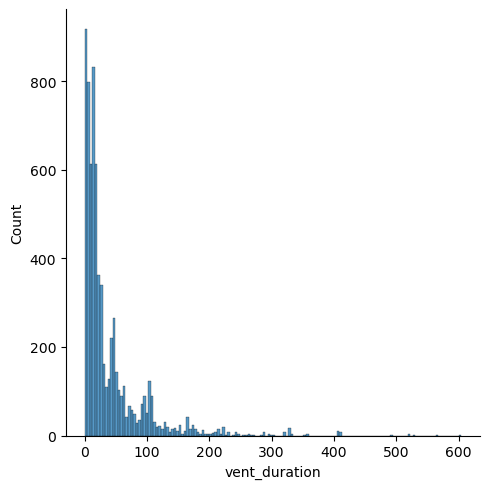

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7024 entries, 0 to 7023
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   stay_id              7024 non-null   int64         
 1   charttime            7024 non-null   datetime64[ns]
 2   total_protein        94 non-null     float64       
 3   calcium              6091 non-null   float64       
 4   creatinine           6763 non-null   float64       
 5   glucose              6580 non-null   float64       
 6   sodium               6810 non-null   float64       
 7   chloride             6783 non-null   float64       
 8   heart_rate           191 non-null    float64       
 9   sbp                  129 non-null    float64       
 10  dbp                  129 non-null    float64       
 11  mbp                  137 non-null    float64       
 12  resp_rate            192 non-null    float64       
 13  temperature          50 non-null 

In [138]:
sns.displot(origin_df['vent_duration'])
plt.show()
origin_df.info()

## Pre-processing

In [139]:
# check the missing rate
missing_ratio = origin_df.isna().sum()/len(origin_df)
drop_miss_df = origin_df.loc[:, missing_ratio < 0.8]

print('missing ratio: ')
print(missing_ratio)
drop_miss_df.columns

missing ratio: 
stay_id                0.000000
charttime              0.000000
total_protein          0.986617
calcium                0.132830
creatinine             0.037158
glucose                0.063212
sodium                 0.030467
chloride               0.034311
heart_rate             0.972808
sbp                    0.981634
dbp                    0.981634
mbp                    0.980495
resp_rate              0.972665
temperature            0.992882
hemoglobin             0.167853
wbc                    0.171839
alt                    0.564351
ast                    0.560364
alp                    0.566059
bilirubin_total        0.563354
bilirubin_direct       0.969248
bilirubin_indirect     0.969818
ph                     0.997153
lactate                0.998292
pt                     0.436788
urineoutput            0.988326
sofa_respiration       0.997295
sofa_coagulation       0.999858
sofa_liver             0.999858
sofa_cardiovascular    0.978360
sofa_cns               0

Index(['stay_id', 'charttime', 'calcium', 'creatinine', 'glucose', 'sodium',
       'chloride', 'hemoglobin', 'wbc', 'alt', 'ast', 'alp', 'bilirubin_total',
       'pt', 'icu_intime', 'vent_start', 'vent_end', 'vent_duration'],
      dtype='object')

In [140]:
# fill nan value
imputed_df = drop_miss_df.groupby('stay_id', as_index=False).apply(lambda x: x.fillna(x.mean(numeric_only=True)))

na_col = list(drop_miss_df.columns[drop_miss_df.isna().sum()>0])

imputer = KNNImputer(n_neighbors=5)
imputed_df[na_col] = pd.DataFrame(imputer.fit_transform(imputed_df[na_col]), columns=na_col, index=imputed_df.index)
imputed_df = imputed_df.sort_values(by=['stay_id', 'charttime'])

imputed_df.describe()


,stay_id,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,alt,ast,alp,bilirubin_total,pt,vent_duration
count,7.024000e+03,7024.000000,7024.000000,7024.000000,7024.000000,7024.000000,7024.000000,7024.000000,7024.000000,7024.000000,7024.000000,7024.000000,7024.000000,7024.000000
mean,3.497892e+07,8.390878,1.636556,142.259010,137.372159,102.086859,10.060769,10.963552,104.190192,161.697388,121.792395,2.937823,17.602165,39.816797
std,2.832325e+06,0.803917,1.825202,87.656487,5.694965,6.821977,2.148713,8.061774,517.018993,955.824042,102.335359,6.133313,9.726403,56.264793
min,3.000414e+07,4.200000,0.100000,30.000000,83.000000,62.000000,3.900000,0.100000,1.000000,5.000000,7.000000,0.100000,9.200000,0.016667
25%,3.255070e+07,7.900000,0.750000,102.000000,134.000000,98.000000,8.400000,6.100000,17.000000,23.000000,67.480462,0.441176,12.900000,8.600000
50%,3.496990e+07,8.400000,1.100000,125.000000,138.000000,102.000000,9.800000,9.500000,30.000000,39.600000,93.000000,0.800000,14.400000,18.766667
75%,3.746081e+07,8.900000,1.800000,159.000000,141.000000,106.000000,11.400000,14.100000,54.175000,79.925000,138.000000,1.900000,18.600000,47.816667
max,3.999217e+07,12.300000,19.700000,2970.000000,185.000000,153.000000,18.400000,125.200000,15018.000000,28275.000000,1185.000000,52.600000,150.000000,604.166667


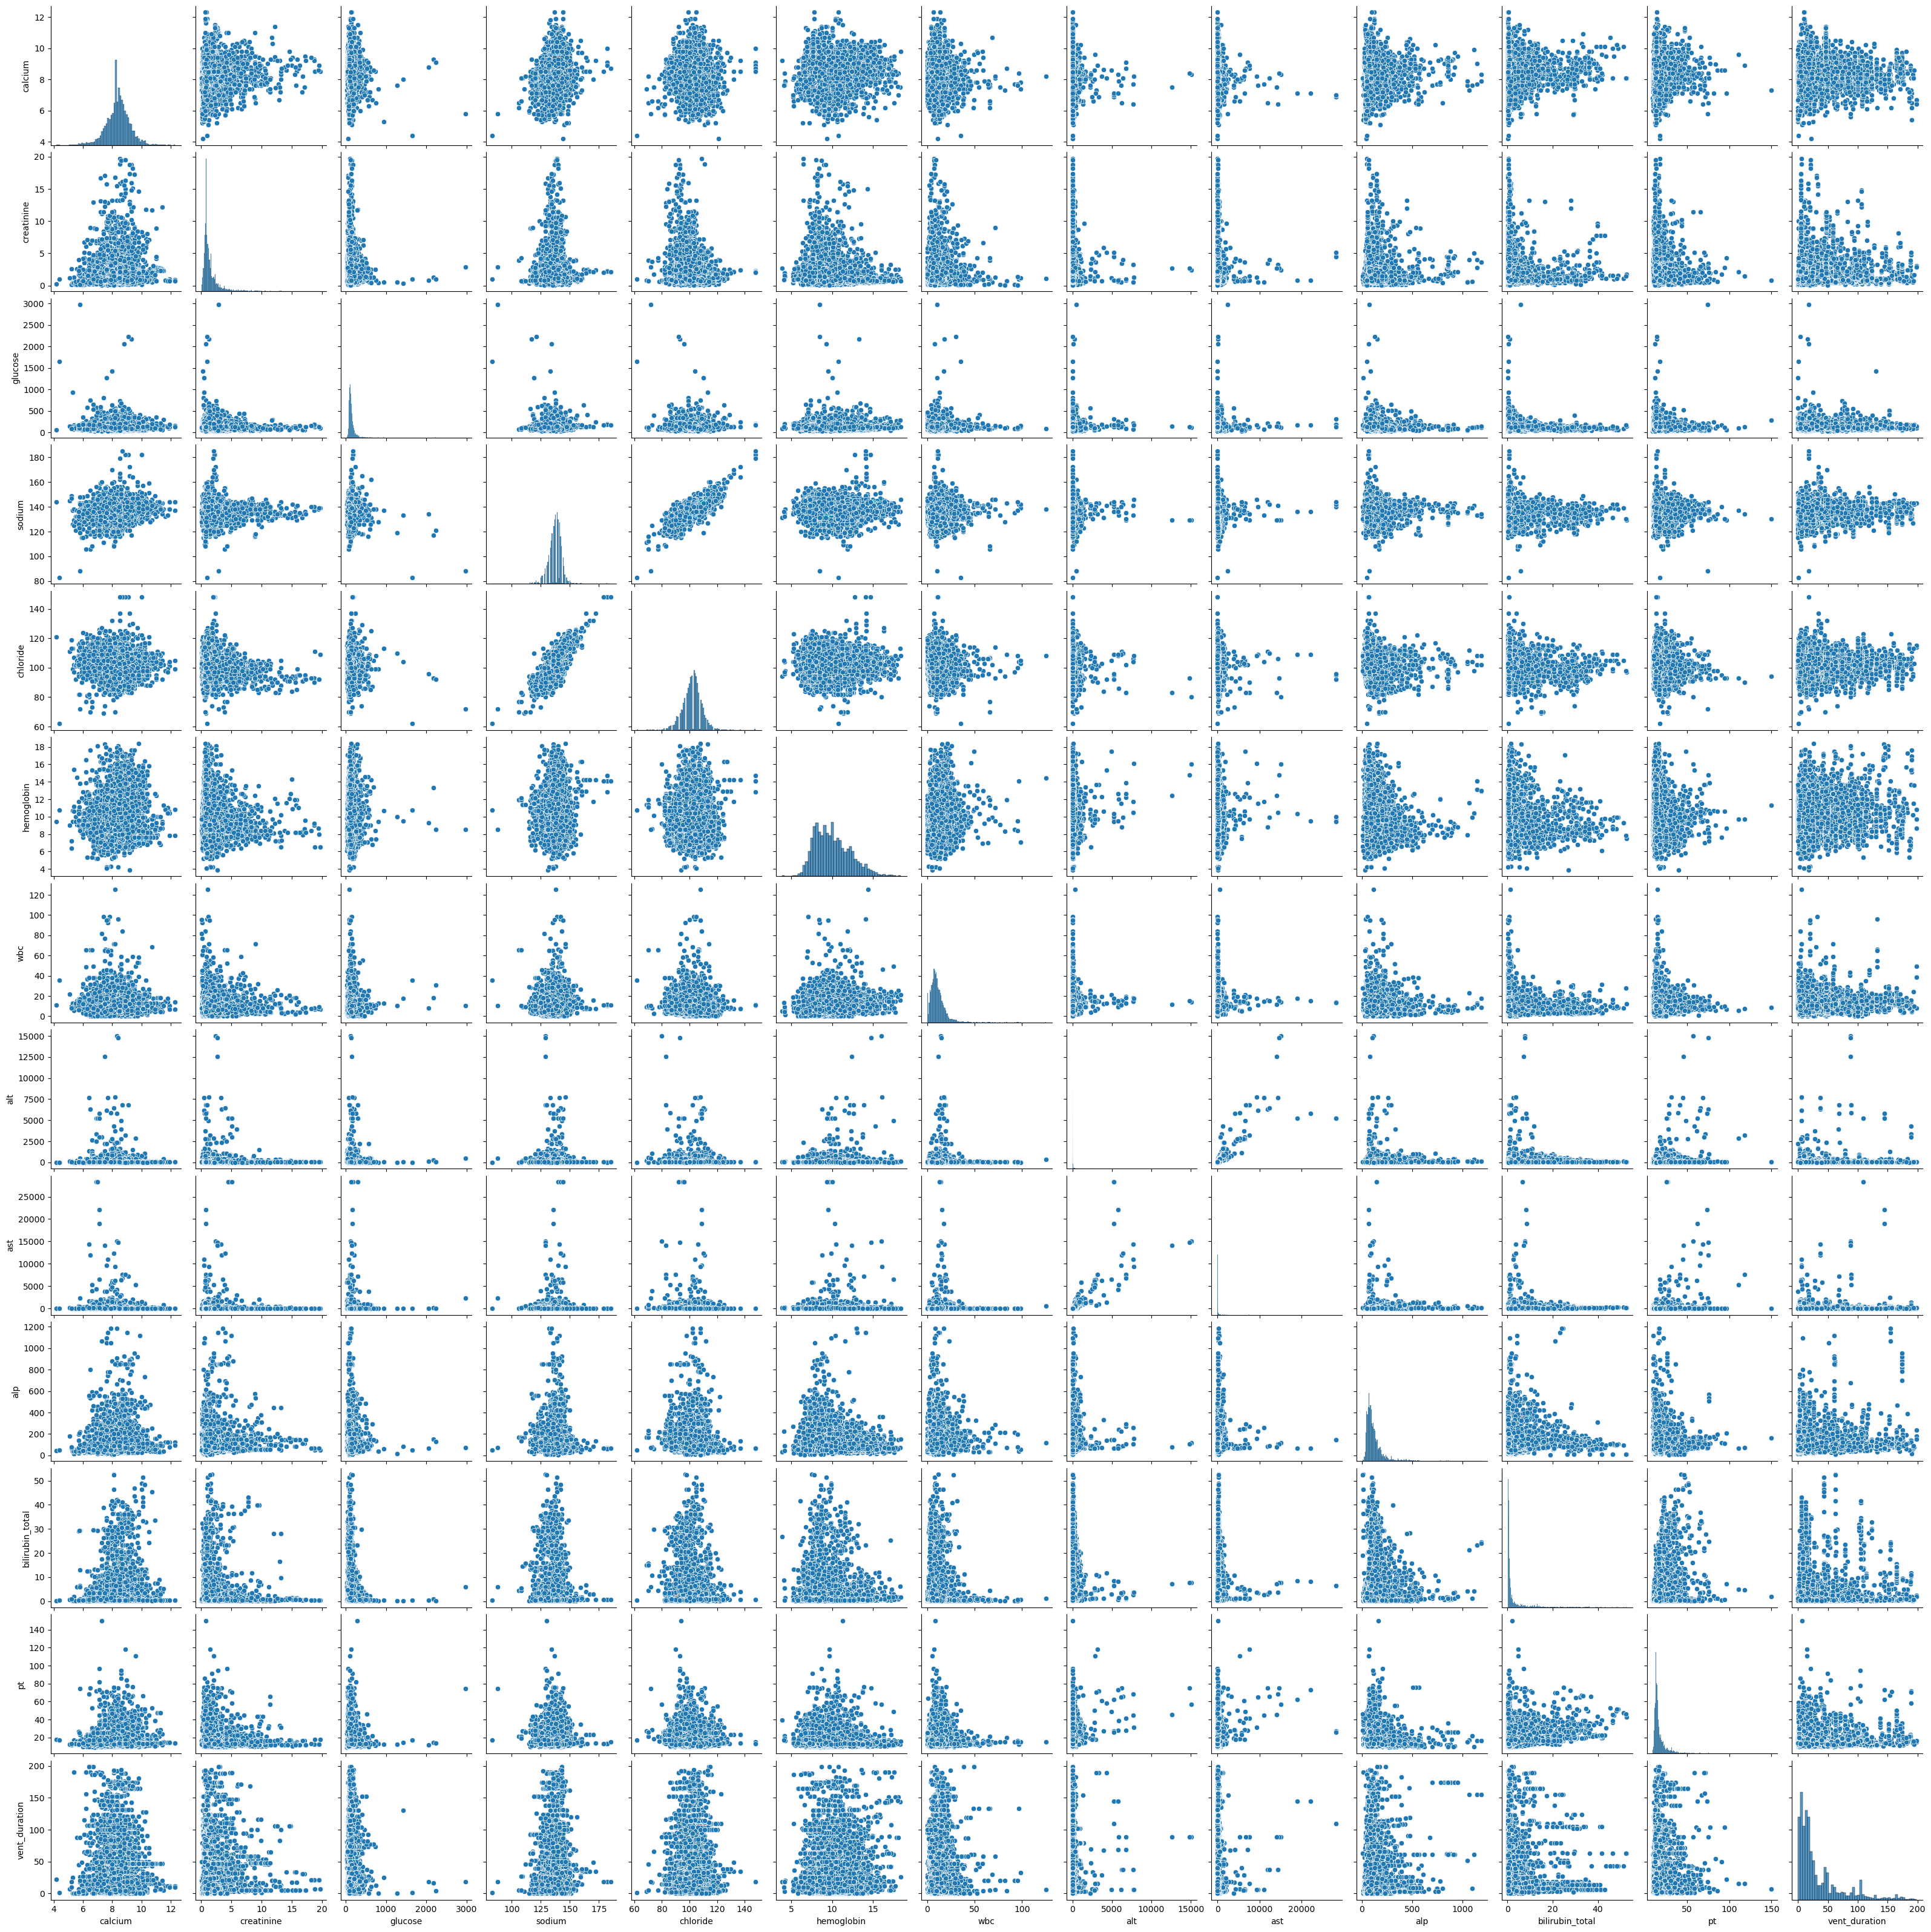

In [36]:
# sns.pairplot(imputed_df.loc[:,['calcium', 'creatinine', 'glucose', 'sodium',
#        'chloride', 'hemoglobin', 'wbc', 'alt', 'ast', 'alp', 'bilirubin_total',
#        'pt', 'vent_duration']])

- **ALT AST ALP**

    ALT stands for alanine aminotransferase, which is an enzyme found primarily in the liver and is often used as a marker for liver damage or disease.The normal range of ALT (alanine aminotransferase) for a healthy adult is typically **between 10-40 U/L (units per liter) in men and 7-35 U/L in women**  (一种主要存在于肝脏中的酶，通常用作**肝损伤或疾病的标志物**)

    AST stands for aspartate aminotransferase, which is another enzyme found in the liver as well as other organs such as the heart and muscles. Like ALT, it is also used as a marker for liver damage or disease.typically **between 10 and 34 U/L or 10 and 34 IU/L** (另一种在**肝脏以及其他器官（如心脏和肌肉）**中发现的酶)

    ALP stands for alkaline phosphatase, which is an enzyme found in many tissues throughout the body, including the liver, bones, and intestines. Elevated levels of ALP can indicate liver or bone disease, among other conditions.For a healthy adult is typically **between 30 and 120 U/L or 30 and 120 IU/L** (一种存在于全身许多组织中的酶，包括肝脏、骨骼和肠道。 ALP 水平升高可能表明存在**肝脏或骨骼疾病等疾病**)

    While it is possible for ALT (alanine aminotransferase) levels to be very high, values as high as 10,000 U/L (units per liter) would be considered extremely elevated and potentially life-threatening.

    Such high levels are typically seen in **acute liver failure or severe liver disease**, such as viral hepatitis, toxic liver injury, or autoimmune hepatitis. Other causes of extremely high ALT levels can include severe muscle injury, such as rhabdomyolysis, or hemolysis (breakdown of red blood cells).


- **calcium 钙**

    The normal range of total calcium in the blood for a healthy adult is typically **between 8.5 and 10.2  mg/dL**


- **creatinine 肌酐**

    The normal range of serum creatinine, which is a waste product that is filtered out of the blood by the kidneys, for a healthy adult is typically **between 0.6 and 1.2 mg/dL for males, and between 0.5 and 1.1 mg/dL for females** (一种由肾脏从血液中滤出的废物)


- **glucose 葡萄糖**

    **Between 70 and 100 mg/dL**,If a person's blood glucose level is consistently outside the normal range, it may be indicative of a medical condition, such as prediabetes, diabetes, or other endocrine disorders. Glucose levels can fluctuate throughout the day depending on various factors, including meals, physical activity, and stress. For random or non-fasting blood glucose, which can be measured at any time during the day and is used to assess blood sugar levels regardless of the last meal, a normal range for a healthy adult is generally **below 140 mg/dL** or 7.8 mmol/L.


- **sodium 钠**

    For a healthy adult is typically **between 135 and 145 mEq/L or 135 and 145 mmol/L**

- **chloride 氯化物**

    For a healthy adult is typically **between 96 and 106 mEq/L or 96 and 106mmol/L**

- **hemoglobin 血红蛋白**

    The normal range of hemoglobin, which is a protein in red blood cells that carries oxygen throughout the body, for a healthy adult is typically **between 12 and 16 g/dL for females, and between 13 and 17.5 g/dL for males**
    
    胆红素水平会受到多种因素的影响，包括年龄、性别、药物、肝脏健康和潜在的医疗状况。 **总胆红素水平升高**可见于影响肝脏的疾病，例如**肝病、肝炎、肝硬化和其他肝脏疾病**。 低于正常水平的胆红素通常无需担心

- **white blood cell (WBC) count 白细胞数量**

    which represents the total number of white blood cells in a given volume of blood, for a healthy adult is typically between 4,000 and 11,000 cells per microliter (µL) or **4.0 and 11.0** x 10^9 cells per liter (L)

- **bilirubin total 总胆红素**

    The normal range of total bilirubin, which is a waste product formed from the breakdown of hemoglobin and processed by the liver, for a healthy adult is typically **between 0.2 and 1.2 milligrams per deciliter (mg/dL) or 3.4 and 20.5 micromoles per liter (µmol/L)**


- **pt （prothrombin time）凝血酶原时间**
    The normal range of prothrombin time (PT), also known as clotting time or coagulation time, for a healthy adult is typically **between 11 and 13 seconds**, or as expressed in International Normalized Ratio (INR), between 0.9 and 1.1


In [155]:
"""
Index(['stay_id', 'charttime', 'calcium', 'creatinine', 'glucose', 'sodium',
       'chloride', 'hemoglobin', 'wbc', 'alt', 'ast', 'alp', 'bilirubin_total',
       'pt', 'icu_intime', 'vent_start', 'vent_end', 'vent_duration'],
      dtype='object')
"""
norm_rng = {
    'calcium': (8, 11), 'creatinine': (0.5, 1.2), 'glucose': (70, 140), 'sodium': (130, 150),
    'chloride': (96, 106), 'hemoglobin': (12, 18), 'wbc': (4, 22), 'alt': (7, 40), 'ast':(10, 35), 
    'alp': (30, 120), 'bilirubin_total': (0.2, 1.2), 'pt': (11, 13)}

metric_col = ['calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 
             'hemoglobin', 'wbc', 'alt', 'ast', 'alp', 'bilirubin_total', 'pt']

imputed_df = imputed_df[imputed_df['vent_duration'] <= 72]
print(len(imputed_df.groupby('stay_id').filter(lambda x: len(x)>=2)['stay_id'].unique()))
print(imputed_df.shape)

974
(5313, 18)


        alt  glucose
4830   44.6    114.0
3369   42.2    133.0
6602  624.0     41.0
387   128.0    133.0
10     46.0    162.0
...     ...      ...
6078    9.0    222.0
1610   37.0    191.0
6496   37.0    208.0
6970   12.0    202.0
799    11.0    149.0

[3196 rows x 2 columns]


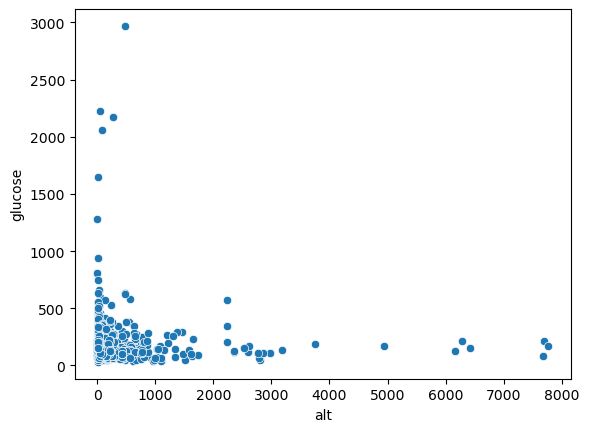

In [150]:
# [calcium', 'creatinine', 'glucose', 'sodium','chloride', 'hemoglobin', 'wbc', 'alt', 'ast', 'alp', 'bilirubin_total','pt']
index_name1 = 'alt'
index_name2 = 'glucose'
# km = KMeans(n_clusters=5).fit(imputed_df[[index_name,'vent_duration']])
temp_df = imputed_df.loc[(imputed_df[index_name1] < norm_rng[index_name1][0])|(imputed_df[index_name1] > norm_rng[index_name1][1])
                         |(imputed_df[index_name2]< norm_rng[index_name2][0])|(imputed_df[index_name2] > norm_rng[index_name2][1]),[index_name1, index_name2]]
print(temp_df)
sns.scatterplot(data=temp_df, x=index_name1, y=index_name2)
plt.show()

In [151]:
# There are some patients who have more than one record at the same charttime
# all reocrd's charttime earlier than vent_start
class SelectPatient:
    def fit(self, X, y=None, **fit_params):
        return self
        
    def transform(self, X, y=None, **fit_params):
        temp_df = X.groupby(['stay_id', 'charttime'], as_index=False).apply(lambda x: x.iloc[-1])
        return temp_df.groupby('stay_id', as_index=False).filter(lambda x:len(x)>=2)
    
class GetNormalDiff:
    def fit(self, X, y=None, **fit_params):
        return self
        
    def transform(self, X, y=None, **fit_params):
        temp_df = X.groupby('stay_id', as_index=False).apply(lambda x: x.sort_values('charttime').iloc[-1])
        for key in metric_col:
            temp_df[key] = temp_df[key].apply(lambda x: 0 if norm_rng[key][0] <= x <= norm_rng[key][1] else (norm_rng[key][0]-x if x < norm_rng[key][0] else x-norm_rng[key][1]))
        return temp_df[metric_col]
        
class GetGradient:     
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):      
        temp_df = X.groupby('stay_id', as_index=False).apply(lambda x: x.sort_values('charttime', ascending=True).tail(2).diff().iloc[-1])
        temp_df['charttime'] = temp_df['charttime'].dt.total_seconds().astype(float) / 3600.
        return temp_df[metric_col] / temp_df['charttime'].values.reshape(-1, 1)

class LastestRecord:
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        temp_df = X.groupby('stay_id', as_index=False).apply(lambda x: x.sort_values('charttime').iloc[-1])
        return temp_df[[*metric_col, 'vent_duration']]
    
feature_transformer = FeatureUnion([('grad', GetGradient()), ('norm_diff', GetNormalDiff()), ('lastest_rec', LastestRecord())])
data_processing_pip = Pipeline([('select', SelectPatient()),('feature_transform', feature_transformer)])

data_arr = data_processing_pip.transform(imputed_df)
print(data_arr.shape)


(973, 37)


In [163]:
X_data, Y_data = data_arr[:, :-1], data_arr[:, -1].reshape(-1, 1)

scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=rng)

print(X_train.shape, X_test.shape)

(681, 36) (292, 36)


## Modelling

In [135]:
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r_2 = r2_score(y_test, y_pred)
print(mse, r_2)


322.72118039390864 -0.05723508336008831


In [159]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 20)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(20, 1)
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        return out

class VentDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X).to(torch.float32)
        self.Y = torch.tensor(Y).to(torch.float32)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
    def __len__(self):
        return len(self.X)

In [160]:

net = Net(X_data.shape[1])

loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)
epoch = 100

train_X, test_X, train_Y, test_Y = train_test_split(X_data, Y_data, test_size=0.2, random_state=rng)

train_dataset = VentDataset(train_X, train_Y)
test_dataset = VentDataset(test_X, test_Y)
print(train_X.shape, train_Y.shape)

train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=200, shuffle=False)

for ep in range(epoch):
    for i, data in enumerate(train_dataloader):
        batch_X, batch_Y = data
        optimizer.zero_grad()

        output = net(batch_X)
        loss = loss_func(output, batch_Y)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        test_loss_ls = []
        for batch_test_X, batch_test_Y in test_dataloader:
            batch_test_output = net(batch_test_X)
            test_loss_ls.append(loss_func(batch_test_output, batch_test_Y).item())
                    
    print('Epoch %d, Train MSE: %0.2f, Test MSE: %0.2f'%(ep, loss.item(), np.mean(test_loss_ls)))


(778, 36) (778, 1)
Epoch 0, Train MSE: 498.31, Test MSE: 430.56
Epoch 1, Train MSE: 477.68, Test MSE: 428.66
Epoch 2, Train MSE: 429.90, Test MSE: 425.73
Epoch 3, Train MSE: 436.80, Test MSE: 421.77
Epoch 4, Train MSE: 459.95, Test MSE: 416.74
Epoch 5, Train MSE: 460.69, Test MSE: 410.79
Epoch 6, Train MSE: 362.68, Test MSE: 403.79
Epoch 7, Train MSE: 337.03, Test MSE: 395.78
Epoch 8, Train MSE: 387.89, Test MSE: 386.63
Epoch 9, Train MSE: 392.05, Test MSE: 376.32
Epoch 10, Train MSE: 441.63, Test MSE: 364.78
Epoch 11, Train MSE: 345.03, Test MSE: 351.80
Epoch 12, Train MSE: 307.40, Test MSE: 337.49
Epoch 13, Train MSE: 343.93, Test MSE: 321.94
Epoch 14, Train MSE: 298.62, Test MSE: 305.59
Epoch 15, Train MSE: 312.70, Test MSE: 288.69
Epoch 16, Train MSE: 236.53, Test MSE: 271.83
Epoch 17, Train MSE: 238.80, Test MSE: 255.49
Epoch 18, Train MSE: 250.80, Test MSE: 240.57
Epoch 19, Train MSE: 228.26, Test MSE: 227.27
Epoch 20, Train MSE: 183.15, Test MSE: 216.07
Epoch 21, Train MSE: 149.

In [162]:
with torch.no_grad():
    y_test_pred = net(torch.Tensor(X_test)).numpy()
    diff = (y_test - y_test_pred).reshape(-1,).astype(int)
    print(diff)
    print(np.abs(diff).mean())


[-15  18  -5   7  29  16   9  24   0  -1  -8   1   8  -9 -10 -14  21   4
  -4 -11   1  11  -6   0   9   3  -7 -11   7   9  11   2  12 -14  -6 -14
   5  -6   3  -5  -3   5   7  -6  -9  10  -6  -4  29  -2   7   8  -4  12
  -2  27   7   0   0  -7 -15  10  -5 -13  27  -7  -8  -4   9  23   2  -8
   6  -5   0  -2 -10  -5   4  21   8  -2 -13  21   0  -1 -13   1  -7  -6
 -12   4   0   0 -10   1  -6  13   9   1  -3  -2  -6  -2  -7  -6  12 -27
  23   1  -6   4  -8  -6  -9  -7  -2  11  -3  23  22  -7  -1   2   6   4
  20  -8 -10   4  23  12  -3   2  -5   9 -11  -6  -6 -16   3  -4 -19  -4
  15  -9 -19 -13   1   4   7  -1  -7  -8  -3  -2  24 -10  -7   2  17   6
   6 -13  -3 -12  -4   1   2  -7  19  -4  -4 -11   0   9   2  19  -3  -3
  -2  25   0  -7  16  -8 -10   5  -2   4  -4   7  17  20  10  21   4  -7
   0 -13   8  -5  -3  -8  29  17   5  -1 -11 -12  -9  -9   0  -6 -10  -2
  -3  -8 -10  19  19 -12  -3 -17  -7 -13  -1  -1  -3   5  -2  10 -12  18
  -2 -10   4  -6   4   4  -8 -23  -7 -13  -9   0  2

In [158]:
torch.save(net, 'nn_model.pth')